In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mplcyberpunk
plt.style.use("cyberpunk")
import cv2
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalMaxPooling2D,GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
from tqdm import tqdm

from warnings import filterwarnings
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
import os

# Klasörün yolu
directory_path = '/content/drive/My Drive/DataSets'

# Klasörün var olup olmadığını kontrol et
if os.path.exists(directory_path):
    print("Klasör mevcut!")
else:
    print("Klasör mevcut değil.")


Klasör mevcut!


In [3]:
X_train = []
y_train = []
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']


image_size = 150
for i in labels:
    folderPath = os.path.join('/content/drive/My Drive/DataSets/Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)

for i in labels:
    folderPath = os.path.join('/content/drive/My Drive/DataSets/Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:00<00:00, 116.20it/s]


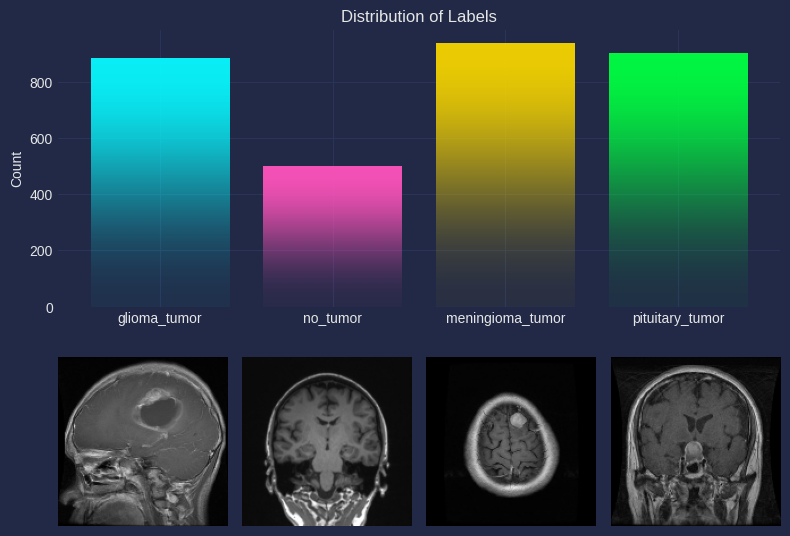

In [5]:
# Calculate the bar plot for each label
label_counts = {label: np.sum(y_train == label) for label in labels}

# Plot the bar plot and sample images in one chart
plt.figure(figsize=(8, 6))

colors = ["C0", "C1", "C2", "C3"]

# Plot the histogram
plt.subplot(2, 1, 1)
bars = plt.bar(label_counts.keys(), label_counts.values(), color=colors)
mplcyberpunk.add_bar_gradient(bars=bars)
# plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Labels')

# Plot sample images from each label
k = 0
for i in labels:
    j = 0
    while True:
        if y_train[j] == i:
            plt.subplot(2, 4, k + 5)
            plt.imshow(X_train[j])
            plt.axis('off')
            k += 1
            break
        j += 1

plt.tight_layout()
plt.show()

In [4]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [5]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

In [6]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [9]:
# Load the EfficientNetB0 model pretrained on ImageNet without the top layers
# EfficientnetB0 modelini ImageNet verisetiyle önceden eğitilmiş ağırlıklarla yüklüyor.
# include_top=False parametresi, üst sınıflandırma katmanlarını kaldırarak, modelin sadece özellik çıkarıcı (feature extractor) olarak kullanılmasını sağlıyor
# input_shape=(image_size, image_size, 3) ile giriş görüntülerinin boyutunu ve renk kanal sayısını belirtiyor.

efficientnetB0 = tf.keras.applications.EfficientNetB0(weights='imagenet',
                                                      include_top=False,
                                                      input_shape=(image_size, image_size, 3))


# Build the custom model on top of the EfficientNetB0 base
model = efficientnetB0.output #Çıkış katmanlarını alıyor.
model = tf.keras.layers.GlobalAveragePooling2D()(model) # En büyük bilgiyi koruyarak boyut küçültme
model = tf.keras.layers.Dense(1024,activation='relu')(model) #Tam bağımlı katman FCl(Her nöronun bir önceki katmandaki tüm nöronlara bağlı olması.) ekler, 1024 nöron Relu fonksiyonu
model = tf.keras.layers.Dropout(rate=0.4)(model)# Overfitting önleme amaçlı bazı nöronları %40 ihtimalle kapatıp rastgele eğitim yaptırır.
model = tf.keras.layers.Dense(4,activation='softmax')(model)#4 tane hastalık oldugu için 4 tane sınıf ve softmax aktivasyon fonk.(Çok sınıflandırma problemlerinde kullanılır.)
model = tf.keras.models.Model(inputs=efficientnetB0.input, outputs = model)#EfficientB0 girişi kullanılarak oluşturdugumuz özel çıkış katmanı ile keras modeli oluşturma.

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [40]:
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9             │ (None, 150, 150, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_18 (Rescaling)  │ (None, 150, 150, 3)    │              0 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_9           │ (None, 150, 150, 3)    │              7 │ rescaling_18[0][0]     │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_19 (Rescaling)  │ (None, 150, 150, 3)    │              0 │ normalization_9[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 151, 151, 3)    │              0 │ rescaling_19[0][0]     │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 75, 75, 32)     │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 75, 75, 32)     │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 75, 75, 32)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 75, 75, 32)     │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 75, 75, 32)     │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 75, 75, 32)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 5,365,415 (20.47 MB)

 Trainable params: 5,323,392 (20.31 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [10]:
# Tensorboard callback for logging training metrics
tensorboard = TensorBoard(log_dir='logs')

# Modelcheckpoint callback to save the best model
checkpoint = ModelCheckpoint("efficientnetB0.keras", monitor="val_accuracy",
                             save_best_only=True, verbose=1)

# ReduceLROnPlateau callback to reduce learning rate if validation accuracy plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2,
                              min_delta=0.0001, verbose=1)

In [11]:
history = model.fit(X_train,y_train,validation_split = 0.1, epochs = 12, verbose = 1,
                    batch_size = 32, callbacks=[tensorboard,checkpoint,reduce_lr])
#X_train ve y_train, modelin eğitileceği görüntü veriseti ve etiketleri.
#validation_split=0.1: Verisetinin %10’u doğrulama için ayrılıyor.
#epochs=12: Model 12 epoch boyunca eğitilecek.
#batch_size=32: 32 görüntü aynı anda eğitime sokuluyor.
#callbacks=[tensorboard, checkpoint, reduce_lr]:
#TensorBoard ile ilerleme kaydediliyor.
#Checkpoint ile en iyi model saklanıyor.
#ReduceLROnPlateau ile öğrenme oranı gerekirse düşürülüyor.
# Epoch tüm eğitim serisinin bir kez tam olarak işlenmesi.(Yüksek epoch overfitting)


Epoch 1/12


KeyboardInterrupt: 

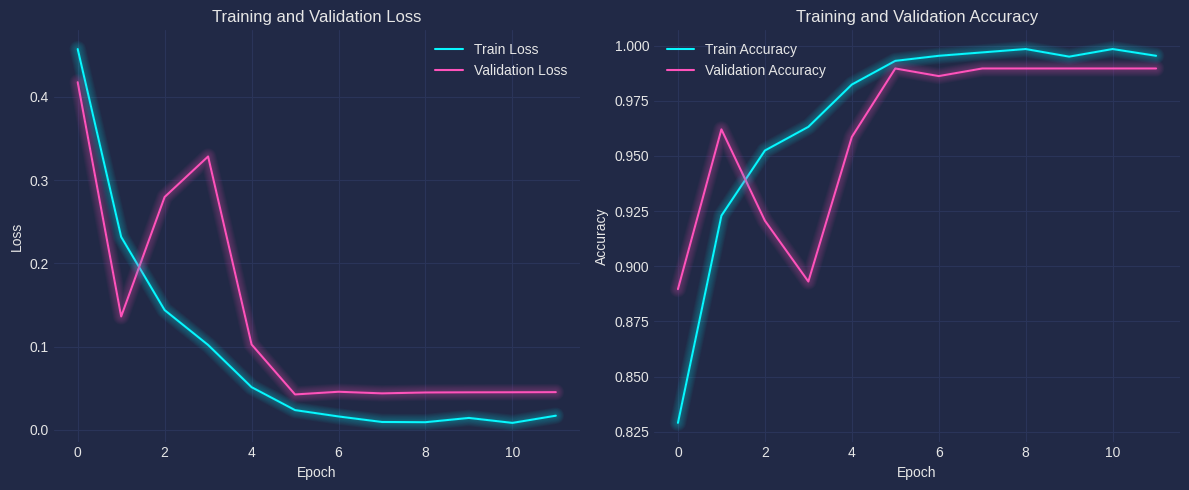

In [43]:
# Plotting training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()

plt.tight_layout()
plt.show()

11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 407ms/step


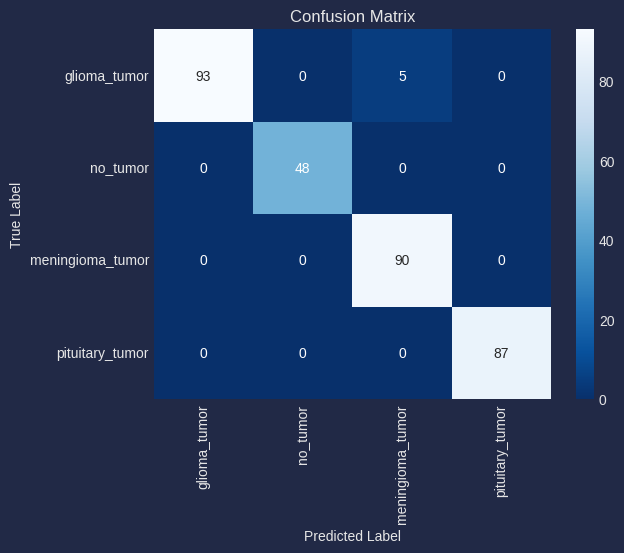

In [45]:
y_true_test = np.argmax(y_test, axis=1)
y_pred_test = np.argmax(model.predict(X_test), axis=1)

heatmap = sns.heatmap(confusion_matrix(y_true_test,y_pred_test), annot=True, fmt='d', cmap='Blues_r',
                      xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [46]:
print(classification_report(y_true_test,y_pred_test))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97        98
           1       1.00      1.00      1.00        48
           2       0.95      1.00      0.97        90
           3       1.00      1.00      1.00        87

    accuracy                           0.98       323
   macro avg       0.99      0.99      0.99       323
weighted avg       0.99      0.98      0.98       323



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted label: glioma_tumor 
Actual label: glioma_tumor 
Confidence: 100.00%



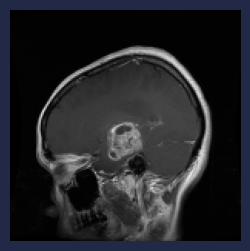

In [48]:
random_index = np.random.randint(0, len(X_test))
random_img = X_test[random_index]
predictions = model.predict(random_img.reshape(1, 150, 150, 3))  # Reshape and preprocess the image

# Interpret the model's predictions
predicted_class = np.argmax(predictions)  # Get the index of the class with the highest probability
predicted_label = labels[predicted_class]  # Convert class to label
confidence = predictions[0][predicted_class]

actual_index = y_test[random_index]  # Get the one-hot encoded actual class
actual_class = np.argmax(actual_index)
actual_label = labels[actual_class]

# Display the image and prediction information
print(f"\033[94mPredicted label: {predicted_label}\033[0m \n\033[92mActual label: {actual_label}\033[0m \n\033[93mConfidence: {confidence*100:.2f}%\033[0m\n")
plt.figure(figsize = (3,3))
plt.imshow(random_img)
plt.axis('off')
plt.show()

In [ ]:
import optuna
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Verinin olduğu dizinler
train_dir = "/content/drive/My Drive/DataSets/Training"  # Eğitim verisi yolu
val_dir = "/content/drive/My Drive/DataSets/Testing"      # Doğrulama verisi yolu

# Görüntü boyutu
IMG_SIZE = (150, 150)  # EfficientNet'in default boyutu 224x224, ancak küçültülebilir

# Veri yükleme için ImageDataGenerator kullanımı
train_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=32, class_mode="categorical"
)
val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=IMG_SIZE, batch_size=32, class_mode="categorical"
)

# Hiperparametreleri optimize eden fonksiyon
def objective(trial):
    # Hiperparametrelerin aralıklarını belirleme
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
    dense_units = trial.suggest_int("dense_units", 128, 1024, step=128)
    dropout_rate = trial.suggest_uniform("dropout_rate", 0.2, 0.5)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])

    # EfficientNetB0 modeli
    base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(150, 150, 3))
    base_model.trainable = False  # Transfer learning için donduruyoruz

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(dense_units, activation="relu")(x)
    x = Dropout(dropout_rate)(x)
    output = Dense(train_generator.num_classes, activation="softmax")(x)

    model = Model(inputs=base_model.input, outputs=output)

    # Model derleme
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    # Modeli eğitme
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=5,  # Daha büyük veri setlerinde artırılabilir
        batch_size=batch_size,
        verbose=0  # Optuna için sessiz çalıştırma
    )

    # En iyi doğrulama doğruluğunu döndür
    val_accuracy = max(history.history["val_accuracy"])
    return val_accuracy

# Optuna çalıştırma
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

# En iyi hiperparametreleri yazdırma
print("En iyi hiperparametreler: ", study.best_params)

Found 2880 images belonging to 4 classes.
Found 342 images belonging to 4 classes.


[I 2025-02-22 10:54:26,529] A new study created in memory with name: no-name-28009f49-13f8-44d3-b57c-f463a379da32
<ipython-input-49-c7e30c98e596>:31: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-49-c7e30c98e596>:33: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.

[I 2025-02-22 10:56:18,296] Trial 0 finished with value: 0.33625730872154236 an

In [12]:
# En iyi hiperparametreler Trial 4'ten:
learning_rate = 0.0005836159432686237
dense_units = 640
dropout_rate = 0.23544464690927264
batch_size = 16

# EfficientNetB0 modelini yükleme (üst katmanları dahil etmiyoruz)
efficientnetB0 = tf.keras.applications.EfficientNetB0(weights='imagenet',
                                                      include_top=False,
                                                      input_shape=(150, 150, 3))

# Base model'den son çıkan özellikleri alıp yeni katmanları ekleyelim
x = tf.keras.layers.GlobalAveragePooling2D()(efficientnetB0.output)
x = tf.keras.layers.Dense(dense_units, activation='relu')(x)
x = tf.keras.layers.Dropout(rate=dropout_rate)(x)
output = tf.keras.layers.Dense(4, activation='softmax')(x)  # 4 sınıf var

# Modeli tanımlayalım
model = tf.keras.models.Model(inputs=efficientnetB0.input, outputs=output)

# Base modelin ağırlıklarını dondurmak (transfer learning)
efficientnetB0.trainable = False

# Callback'ler
tensorboard = tf.keras.callbacks.TensorBoard(log_dir='logs')
checkpoint = tf.keras.callbacks.ModelCheckpoint("efficientnetB0.keras", monitor="val_accuracy",
                                                save_best_only=True, verbose=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2,
                                                 min_delta=0.0001, verbose=1)

# Model derleme
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Modeli eğitme
history = model.fit(X_train, y_train, validation_split=0.1, epochs=12, verbose=1,
                    batch_size=batch_size, callbacks=[tensorboard, checkpoint, reduce_lr])


Epoch 1/12
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.6436 - loss: 0.8138
Epoch 1: val_accuracy improved from -inf to 0.85517, saving model to efficientnetB0.keras
164/164 ━━━━━━━━━━━━━━━━━━━━ 47s 145ms/step - accuracy: 0.6442 - loss: 0.8128 - val_accuracy: 0.8552 - val_loss: 0.3712 - learning_rate: 5.8362e-04
Epoch 2/12
162/164 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8487 - loss: 0.4183
Epoch 2: val_accuracy did not improve from 0.85517
164/164 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.8489 - loss: 0.4177 - val_accuracy: 0.8448 - val_loss: 0.3740 - learning_rate: 5.8362e-04
Epoch 3/12
163/164 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8693 - loss: 0.3310
Epoch 3: val_accuracy improved from 0.85517 to 0.88621, saving model to efficientnetB0.keras
164/164 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8694 - loss: 0.3310 - val_accuracy: 0.8862 - val_loss: 0.2694 - learning_rate: 5.8362e-04
Epoch 4/12
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 

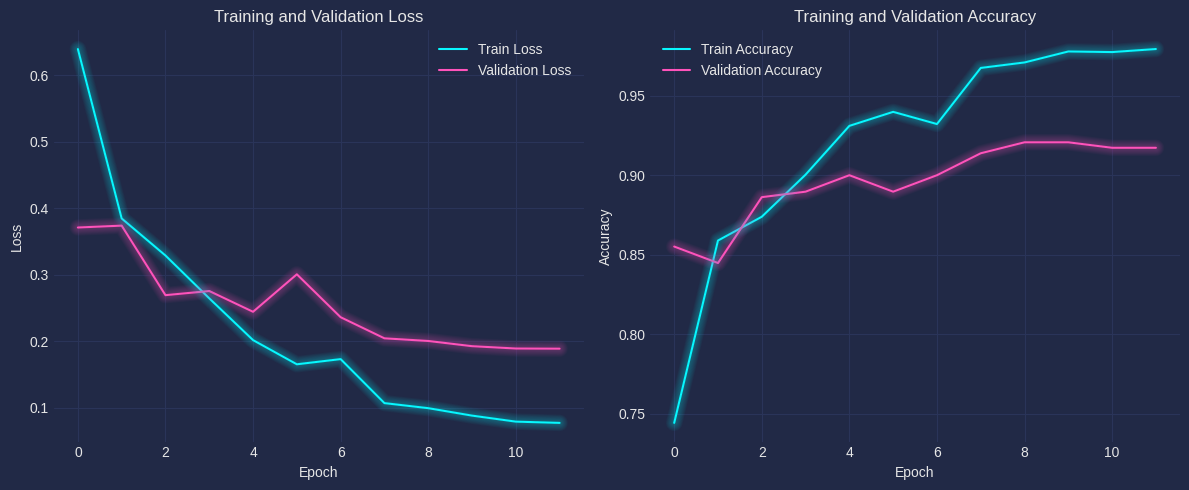

In [13]:
# Plotting training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted label: meningioma_tumor 
Actual label: glioma_tumor 
Confidence: 97.05%



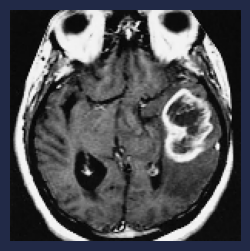

In [22]:
random_index = np.random.randint(0, len(X_test))
random_img = X_test[random_index]
predictions = model.predict(random_img.reshape(1, 150, 150, 3))  # Reshape and preprocess the image

# Interpret the model's predictions
predicted_class = np.argmax(predictions)  # Get the index of the class with the highest probability
predicted_label = labels[predicted_class]  # Convert class to label
confidence = predictions[0][predicted_class]

actual_index = y_test[random_index]  # Get the one-hot encoded actual class
actual_class = np.argmax(actual_index)
actual_label = labels[actual_class]

# Display the image and prediction information
print(f"\033[94mPredicted label: {predicted_label}\033[0m \n\033[92mActual label: {actual_label}\033[0m \n\033[93mConfidence: {confidence*100:.2f}%\033[0m\n")
plt.figure(figsize = (3,3))
plt.imshow(random_img)
plt.axis('off')
plt.show()

11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 434ms/step


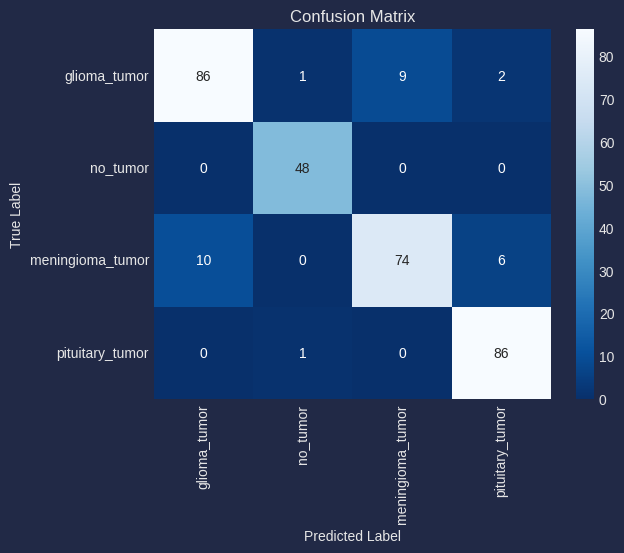

In [17]:
y_true_test = np.argmax(y_test, axis=1)
y_pred_test = np.argmax(model.predict(X_test), axis=1)

heatmap = sns.heatmap(confusion_matrix(y_true_test,y_pred_test), annot=True, fmt='d', cmap='Blues_r',
                      xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [18]:
print(classification_report(y_true_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89        98
           1       0.96      1.00      0.98        48
           2       0.89      0.82      0.86        90
           3       0.91      0.99      0.95        87

    accuracy                           0.91       323
   macro avg       0.92      0.92      0.92       323
weighted avg       0.91      0.91      0.91       323



In [2]:
# Load the ResNet101 model pretrained on ImageNet without the top layers
resnet = tf.keras.applications.ResNet101(weights='imagenet', include_top=False,
                                         input_shape=(image_size, image_size, 3))

# Build the custom model on top of the ResNet101 base

model = resnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=resnet.input, outputs = model)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

NameError: name 'tf' is not defined

In [24]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 150, 150, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 156, 156, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 75, 75, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 75, 75, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 75, 75, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 77, 77, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 38, 38, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 38, 38, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 38, 38, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 38, 38, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 38, 38, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 38, 38, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 38, 38, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 38, 38, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 38, 38, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 42,666,372 (162.76 MB)

 Trainable params: 42,561,028 (162.36 MB)

 Non-trainable params: 105,344 (411.50 KB)

In [49]:
# Tensorboard callback for logging training metrics
tensorboard = TensorBoard(log_dir='logs')

# Modelcheckpoint callback to save the best model
checkpoint = ModelCheckpoint("resnet50_best.keras", monitor="val_accuracy",
                             save_best_only=True, verbose=1)

# ReduceLROnPlateau callback to reduce learning rate if validation accuracy plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2,
                              min_delta=0.0001, verbose=1)

In [1]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =15, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

NameError: name 'model' is not defined

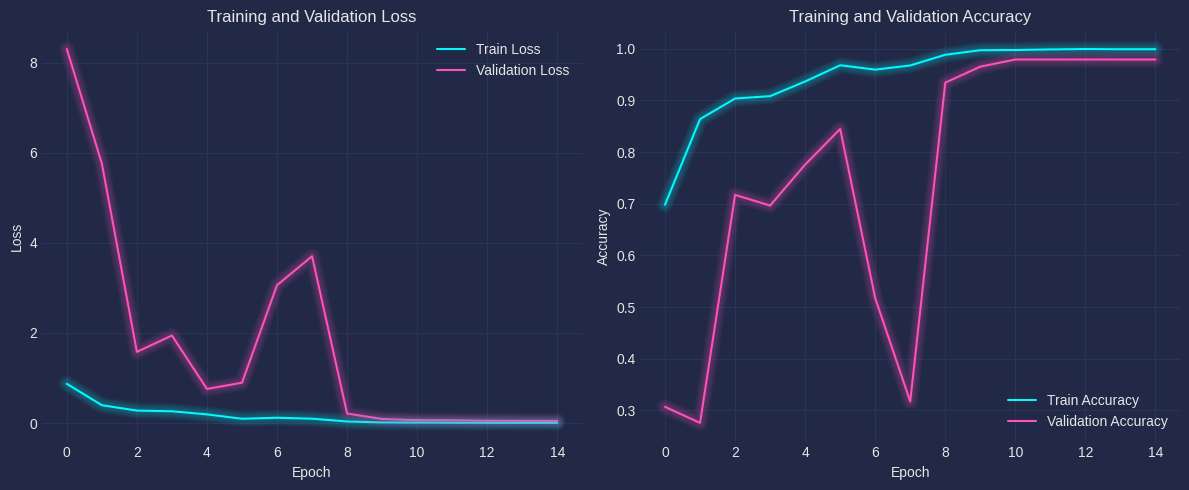

In [27]:
# Plotting training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()

plt.tight_layout()
plt.show()

11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 972ms/step


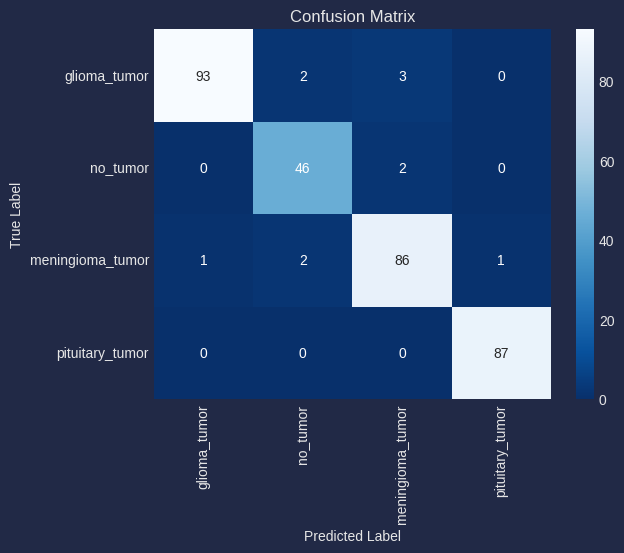

In [28]:
y_true_test = np.argmax(y_test, axis=1)
y_pred_test = np.argmax(model.predict(X_test), axis=1)

heatmap = sns.heatmap(confusion_matrix(y_true_test,y_pred_test), annot=True, fmt='d', cmap='Blues_r',
                      xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [29]:
print(classification_report(y_true_test,y_pred_test))


              precision    recall  f1-score   support

           0       0.99      0.95      0.97        98
           1       0.92      0.96      0.94        48
           2       0.95      0.96      0.95        90
           3       0.99      1.00      0.99        87

    accuracy                           0.97       323
   macro avg       0.96      0.97      0.96       323
weighted avg       0.97      0.97      0.97       323



1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted label: meningioma_tumor 
Actual label: meningioma_tumor 
Confidence: 100.00%



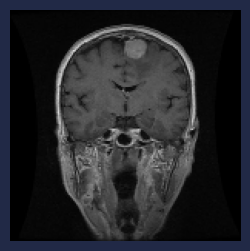

In [30]:
random_index = np.random.randint(0, len(X_test))
random_img = X_test[random_index]
predictions = model.predict(random_img.reshape(1, 150, 150, 3))  # Reshape and preprocess the image

# Interpret the model's predictions
predicted_class = np.argmax(predictions)  # Get the index of the class with the highest probability
predicted_label = labels[predicted_class]  # Convert class to label
confidence = predictions[0][predicted_class]

actual_index = y_test[random_index]  # Get the one-hot encoded actual class
actual_class = np.argmax(actual_index)
actual_label = labels[actual_class]

# Display the image and prediction information
print(f"\033[94mPredicted label: {predicted_label}\033[0m \n\033[92mActual label: {actual_label}\033[0m \n\033[93mConfidence: {confidence*100:.2f}%\033[0m\n")
plt.figure(figsize = (3,3))
plt.imshow(random_img)
plt.axis('off')
plt.show()

In [31]:
import optuna
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau

# Verinin olduğu dizinler
train_dir = "/content/drive/My Drive/DataSets/Training"  # Eğitim verisi yolu
val_dir = "/content/drive/My Drive/DataSets/Testing"      # Doğrulama verisi yolu

# Görüntü boyutu
IMG_SIZE = (150, 150)  # ResNet50 için de bu boyut kullanılabilir

# Veri yükleme için ImageDataGenerator kullanımı
train_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=32, class_mode="categorical"
)
val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=IMG_SIZE, batch_size=32, class_mode="categorical"
)

# Hiperparametreleri optimize eden fonksiyon
def objective(trial):
    # Hiperparametre aralıklarını belirleme
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
    dense_units = trial.suggest_int("dense_units", 128, 1024, step=128)
    dropout_rate = trial.suggest_uniform("dropout_rate", 0.2, 0.5)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])

    # ResNet50 modeli
    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    base_model.trainable = False  # Transfer learning için donduruyoruz

    # Üst katmanları inşa etme
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(dense_units, activation="relu")(x)
    x = Dropout(dropout_rate)(x)
    output = Dense(train_generator.num_classes, activation="softmax")(x)

    model = Model(inputs=base_model.input, outputs=output)

    # Callback'leri tanımlama
    tensorboard = TensorBoard(log_dir='logs')
    checkpoint = ModelCheckpoint("resnet50_best.keras", monitor="val_accuracy",
                                 save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2,
                                  min_delta=0.0001, verbose=1)

    # Model derleme
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    # Modeli eğitme
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=5,  # Daha büyük veri setlerinde artırılabilir
        batch_size=batch_size,  # Not: Generator zaten batch_size belirtiyor,
                                # bu parametre fit()'te genelde kullanılmaz ama burada denemek için bırakıldı.
        callbacks=[tensorboard, checkpoint, reduce_lr],
        verbose=0  # Optuna için sessiz çalıştırma
    )

    # En iyi doğrulama doğruluğunu döndür
    val_accuracy = max(history.history["val_accuracy"])
    return val_accuracy

# Optuna çalıştırma
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

# En iyi hiperparametreleri yazdırma
print("En iyi hiperparametreler: ", study.best_params)


Found 2880 images belonging to 4 classes.
Found 342 images belonging to 4 classes.


[I 2025-02-22 11:59:53,285] A new study created in memory with name: no-name-0904b61a-0a1a-4116-a64b-3d262ba2551d
<ipython-input-31-1d4117ca9996>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-31-1d4117ca9996>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform("dropout_rate", 0.2, 0.5)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from -inf to 0.32749, saving model to resnet50_best.keras

Epoch 2: val_accuracy improved from 0.32749 to 0.36257, saving model to resnet50_best.keras

Epoch 3: val_accuracy improved from 0.36257 to 0.36842, saving model to resnet50_best.keras

Epoch 4: val_accuracy did not improve from 0.36842

Epoch 5: val_accuracy did not improve from 0.36842

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0008537313900887967.


[I 2025-02-22 12:01:36,827] Trial 0 finished with value: 0.3684210479259491 and parameters: {'learning_rate': 0.008537313689674983, 'dense_units': 640, 'dropout_rate': 0.27857164779687293, 'batch_size': 16}. Best is trial 0 with value: 0.3684210479259491.



Epoch 1: val_accuracy improved from -inf to 0.26316, saving model to resnet50_best.keras

Epoch 2: val_accuracy improved from 0.26316 to 0.30409, saving model to resnet50_best.keras

Epoch 3: val_accuracy improved from 0.30409 to 0.36842, saving model to resnet50_best.keras

Epoch 4: val_accuracy did not improve from 0.36842

Epoch 5: val_accuracy improved from 0.36842 to 0.40058, saving model to resnet50_best.keras


[I 2025-02-22 12:03:33,536] Trial 1 finished with value: 0.40058478713035583 and parameters: {'learning_rate': 0.0020885304249660835, 'dense_units': 1024, 'dropout_rate': 0.36285606174059537, 'batch_size': 32}. Best is trial 1 with value: 0.40058478713035583.



Epoch 1: val_accuracy improved from -inf to 0.35088, saving model to resnet50_best.keras

Epoch 2: val_accuracy did not improve from 0.35088

Epoch 3: val_accuracy did not improve from 0.35088

Epoch 3: ReduceLROnPlateau reducing learning rate to 6.113899144111201e-06.

Epoch 4: val_accuracy did not improve from 0.35088

Epoch 5: val_accuracy did not improve from 0.35088

Epoch 5: ReduceLROnPlateau reducing learning rate to 6.113898962212261e-07.


[I 2025-02-22 12:05:18,213] Trial 2 finished with value: 0.35087719559669495 and parameters: {'learning_rate': 6.11389919367909e-05, 'dense_units': 768, 'dropout_rate': 0.2886649239734514, 'batch_size': 32}. Best is trial 1 with value: 0.40058478713035583.



Epoch 1: val_accuracy improved from -inf to 0.38012, saving model to resnet50_best.keras

Epoch 2: val_accuracy did not improve from 0.38012

Epoch 3: val_accuracy did not improve from 0.38012

Epoch 3: ReduceLROnPlateau reducing learning rate to 2.1272404410410672e-05.

Epoch 4: val_accuracy did not improve from 0.38012

Epoch 5: val_accuracy did not improve from 0.38012

Epoch 5: ReduceLROnPlateau reducing learning rate to 2.1272404410410673e-06.


[I 2025-02-22 12:06:52,177] Trial 3 finished with value: 0.3801169693470001 and parameters: {'learning_rate': 0.00021272405112173024, 'dense_units': 384, 'dropout_rate': 0.4980515559962756, 'batch_size': 16}. Best is trial 1 with value: 0.40058478713035583.



Epoch 1: val_accuracy improved from -inf to 0.34795, saving model to resnet50_best.keras

Epoch 2: val_accuracy did not improve from 0.34795

Epoch 3: val_accuracy did not improve from 0.34795

Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9339444406796247e-05.

Epoch 4: val_accuracy did not improve from 0.34795

Epoch 5: val_accuracy improved from 0.34795 to 0.36550, saving model to resnet50_best.keras


[I 2025-02-22 12:08:36,479] Trial 4 finished with value: 0.36549708247184753 and parameters: {'learning_rate': 0.00019339443903130767, 'dense_units': 1024, 'dropout_rate': 0.3418235449016206, 'batch_size': 16}. Best is trial 1 with value: 0.40058478713035583.



Epoch 1: val_accuracy improved from -inf to 0.36257, saving model to resnet50_best.keras

Epoch 2: val_accuracy did not improve from 0.36257

Epoch 3: val_accuracy did not improve from 0.36257

Epoch 3: ReduceLROnPlateau reducing learning rate to 1.7512589693069458e-05.

Epoch 4: val_accuracy did not improve from 0.36257

Epoch 5: val_accuracy did not improve from 0.36257

Epoch 5: ReduceLROnPlateau reducing learning rate to 1.7512589693069459e-06.


[I 2025-02-22 12:10:10,378] Trial 5 finished with value: 0.3625730872154236 and parameters: {'learning_rate': 0.00017512590289649687, 'dense_units': 1024, 'dropout_rate': 0.34613849470915425, 'batch_size': 32}. Best is trial 1 with value: 0.40058478713035583.



Epoch 1: val_accuracy improved from -inf to 0.30409, saving model to resnet50_best.keras

Epoch 2: val_accuracy did not improve from 0.30409

Epoch 3: val_accuracy did not improve from 0.30409

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0002609146060422063.

Epoch 4: val_accuracy improved from 0.30409 to 0.33918, saving model to resnet50_best.keras

Epoch 5: val_accuracy improved from 0.33918 to 0.34211, saving model to resnet50_best.keras


[I 2025-02-22 12:11:47,649] Trial 6 finished with value: 0.34210526943206787 and parameters: {'learning_rate': 0.0026091460299833974, 'dense_units': 640, 'dropout_rate': 0.36117886229512997, 'batch_size': 32}. Best is trial 1 with value: 0.40058478713035583.



Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to resnet50_best.keras

Epoch 2: val_accuracy improved from 0.33333 to 0.39474, saving model to resnet50_best.keras

Epoch 3: val_accuracy did not improve from 0.39474

Epoch 4: val_accuracy did not improve from 0.39474

Epoch 4: ReduceLROnPlateau reducing learning rate to 1.624445285415277e-05.

Epoch 5: val_accuracy did not improve from 0.39474


[I 2025-02-22 12:13:36,893] Trial 7 finished with value: 0.3947368562221527 and parameters: {'learning_rate': 0.00016244453197004669, 'dense_units': 640, 'dropout_rate': 0.21251627122411976, 'batch_size': 32}. Best is trial 1 with value: 0.40058478713035583.



Epoch 1: val_accuracy improved from -inf to 0.28947, saving model to resnet50_best.keras

Epoch 2: val_accuracy improved from 0.28947 to 0.30702, saving model to resnet50_best.keras

Epoch 3: val_accuracy improved from 0.30702 to 0.37427, saving model to resnet50_best.keras

Epoch 4: val_accuracy did not improve from 0.37427

Epoch 5: val_accuracy did not improve from 0.37427

Epoch 5: ReduceLROnPlateau reducing learning rate to 6.1031623044982555e-05.


[I 2025-02-22 12:15:28,205] Trial 8 finished with value: 0.3742690086364746 and parameters: {'learning_rate': 0.0006103162300540644, 'dense_units': 768, 'dropout_rate': 0.4492144407507842, 'batch_size': 16}. Best is trial 1 with value: 0.40058478713035583.



Epoch 1: val_accuracy improved from -inf to 0.37427, saving model to resnet50_best.keras

Epoch 2: val_accuracy did not improve from 0.37427

Epoch 3: val_accuracy did not improve from 0.37427

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.61895503778942e-06.

Epoch 4: val_accuracy did not improve from 0.37427

Epoch 5: val_accuracy did not improve from 0.37427

Epoch 5: ReduceLROnPlateau reducing learning rate to 5.61895512873889e-07.


[I 2025-02-22 12:17:22,596] Trial 9 finished with value: 0.3742690086364746 and parameters: {'learning_rate': 5.618955162714389e-05, 'dense_units': 768, 'dropout_rate': 0.46545377116332204, 'batch_size': 64}. Best is trial 1 with value: 0.40058478713035583.



Epoch 1: val_accuracy improved from -inf to 0.27193, saving model to resnet50_best.keras

Epoch 2: val_accuracy improved from 0.27193 to 0.33041, saving model to resnet50_best.keras

Epoch 3: val_accuracy improved from 0.33041 to 0.35965, saving model to resnet50_best.keras

Epoch 4: val_accuracy did not improve from 0.35965

Epoch 5: val_accuracy did not improve from 0.35965

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0001266377163119614.


[I 2025-02-22 12:19:02,608] Trial 10 finished with value: 0.359649121761322 and parameters: {'learning_rate': 0.0012663771605515549, 'dense_units': 128, 'dropout_rate': 0.40104104860022466, 'batch_size': 64}. Best is trial 1 with value: 0.40058478713035583.



Epoch 1: val_accuracy improved from -inf to 0.25439, saving model to resnet50_best.keras

Epoch 2: val_accuracy improved from 0.25439 to 0.26023, saving model to resnet50_best.keras

Epoch 3: val_accuracy improved from 0.26023 to 0.33333, saving model to resnet50_best.keras

Epoch 4: val_accuracy improved from 0.33333 to 0.35088, saving model to resnet50_best.keras

Epoch 5: val_accuracy improved from 0.35088 to 0.35965, saving model to resnet50_best.keras


[I 2025-02-22 12:20:46,555] Trial 11 finished with value: 0.359649121761322 and parameters: {'learning_rate': 1.196753540202641e-05, 'dense_units': 384, 'dropout_rate': 0.2039034497499764, 'batch_size': 32}. Best is trial 1 with value: 0.40058478713035583.



Epoch 1: val_accuracy improved from -inf to 0.26316, saving model to resnet50_best.keras

Epoch 2: val_accuracy improved from 0.26316 to 0.38012, saving model to resnet50_best.keras

Epoch 3: val_accuracy did not improve from 0.38012

Epoch 4: val_accuracy did not improve from 0.38012

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0004553381353616715.

Epoch 5: val_accuracy did not improve from 0.38012


[I 2025-02-22 12:22:23,190] Trial 12 finished with value: 0.3801169693470001 and parameters: {'learning_rate': 0.004553381349319318, 'dense_units': 1024, 'dropout_rate': 0.21954405676971517, 'batch_size': 32}. Best is trial 1 with value: 0.40058478713035583.



Epoch 1: val_accuracy improved from -inf to 0.27778, saving model to resnet50_best.keras

Epoch 2: val_accuracy improved from 0.27778 to 0.30702, saving model to resnet50_best.keras

Epoch 3: val_accuracy did not improve from 0.30702

Epoch 4: val_accuracy improved from 0.30702 to 0.35965, saving model to resnet50_best.keras

Epoch 5: val_accuracy did not improve from 0.35965


[I 2025-02-22 12:24:06,864] Trial 13 finished with value: 0.359649121761322 and parameters: {'learning_rate': 0.0007901991579860043, 'dense_units': 384, 'dropout_rate': 0.28283669380624776, 'batch_size': 32}. Best is trial 1 with value: 0.40058478713035583.



Epoch 1: val_accuracy improved from -inf to 0.28070, saving model to resnet50_best.keras

Epoch 2: val_accuracy improved from 0.28070 to 0.35673, saving model to resnet50_best.keras

Epoch 3: val_accuracy did not improve from 0.35673

Epoch 4: val_accuracy did not improve from 0.35673

Epoch 4: ReduceLROnPlateau reducing learning rate to 6.284093979047612e-06.

Epoch 5: val_accuracy did not improve from 0.35673


[I 2025-02-22 12:25:53,387] Trial 14 finished with value: 0.35672515630722046 and parameters: {'learning_rate': 6.284094061050776e-05, 'dense_units': 896, 'dropout_rate': 0.3956824491542157, 'batch_size': 32}. Best is trial 1 with value: 0.40058478713035583.



Epoch 1: val_accuracy improved from -inf to 0.31871, saving model to resnet50_best.keras

Epoch 2: val_accuracy did not improve from 0.31871

Epoch 3: val_accuracy improved from 0.31871 to 0.32749, saving model to resnet50_best.keras

Epoch 4: val_accuracy improved from 0.32749 to 0.33918, saving model to resnet50_best.keras

Epoch 5: val_accuracy improved from 0.33918 to 0.35088, saving model to resnet50_best.keras


[I 2025-02-22 12:28:47,828] Trial 15 finished with value: 0.35087719559669495 and parameters: {'learning_rate': 0.0019838965061144253, 'dense_units': 128, 'dropout_rate': 0.24921488364346778, 'batch_size': 32}. Best is trial 1 with value: 0.40058478713035583.



Epoch 1: val_accuracy improved from -inf to 0.28070, saving model to resnet50_best.keras

Epoch 2: val_accuracy improved from 0.28070 to 0.29825, saving model to resnet50_best.keras

Epoch 3: val_accuracy improved from 0.29825 to 0.34211, saving model to resnet50_best.keras

Epoch 4: val_accuracy did not improve from 0.34211

Epoch 5: val_accuracy did not improve from 0.34211

Epoch 5: ReduceLROnPlateau reducing learning rate to 4.562502435874194e-05.


[I 2025-02-22 12:30:42,323] Trial 16 finished with value: 0.34210526943206787 and parameters: {'learning_rate': 0.0004562502581139929, 'dense_units': 512, 'dropout_rate': 0.31277911046513973, 'batch_size': 64}. Best is trial 1 with value: 0.40058478713035583.



Epoch 1: val_accuracy improved from -inf to 0.26608, saving model to resnet50_best.keras

Epoch 2: val_accuracy improved from 0.26608 to 0.38012, saving model to resnet50_best.keras

Epoch 3: val_accuracy did not improve from 0.38012

Epoch 4: val_accuracy did not improve from 0.38012

Epoch 4: ReduceLROnPlateau reducing learning rate to 1.7539159671287052e-06.

Epoch 5: val_accuracy did not improve from 0.38012


[I 2025-02-22 12:32:43,578] Trial 17 finished with value: 0.3801169693470001 and parameters: {'learning_rate': 1.753916054882286e-05, 'dense_units': 896, 'dropout_rate': 0.4075623819576402, 'batch_size': 32}. Best is trial 1 with value: 0.40058478713035583.



Epoch 1: val_accuracy improved from -inf to 0.35965, saving model to resnet50_best.keras

Epoch 2: val_accuracy did not improve from 0.35965

Epoch 3: val_accuracy did not improve from 0.35965

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0007343038450926542.

Epoch 4: val_accuracy did not improve from 0.35965

Epoch 5: val_accuracy did not improve from 0.35965

Epoch 5: ReduceLROnPlateau reducing learning rate to 7.343038450926543e-05.


[I 2025-02-22 12:34:31,414] Trial 18 finished with value: 0.359649121761322 and parameters: {'learning_rate': 0.0073430385208333206, 'dense_units': 512, 'dropout_rate': 0.2388202834442516, 'batch_size': 32}. Best is trial 1 with value: 0.40058478713035583.



Epoch 1: val_accuracy improved from -inf to 0.27193, saving model to resnet50_best.keras

Epoch 2: val_accuracy improved from 0.27193 to 0.30994, saving model to resnet50_best.keras

Epoch 3: val_accuracy improved from 0.30994 to 0.31871, saving model to resnet50_best.keras

Epoch 4: val_accuracy did not improve from 0.31871

Epoch 5: val_accuracy did not improve from 0.31871

Epoch 5: ReduceLROnPlateau reducing learning rate to 1.068138735718094e-05.


[I 2025-02-22 12:36:42,161] Trial 19 finished with value: 0.3187134563922882 and parameters: {'learning_rate': 0.00010681387545625208, 'dense_units': 256, 'dropout_rate': 0.3169940066643663, 'batch_size': 64}. Best is trial 1 with value: 0.40058478713035583.


En iyi hiperparametreler:  {'learning_rate': 0.0020885304249660835, 'dense_units': 1024, 'dropout_rate': 0.36285606174059537, 'batch_size': 32}


In [39]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau

# Hiperparametreler (Optuna sonucuna göre):
learning_rate = 0.0020885304249660835
dense_units = 1024
dropout_rate = 0.36285606174059537
batch_size = 32

# Modelin girdi boyutu (örneğin 150x150)
image_size = 150

# EfficientNetB0 modelini yükleme (üst katmanlar hariç)
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
base_model.trainable = False  # Transfer learning için tabanı donduruyoruz

# Üst katmanların inşa edilmesi
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(dense_units, activation='relu')(x)
x = Dropout(dropout_rate)(x)
output = Dense(4, activation='softmax')(x)  # 4 sınıf varsayımıyla

# Modeli oluşturma
model = Model(inputs=base_model.input, outputs=output)

# Callback'leri tanımlama
tensorboard = TensorBoard(log_dir='logs')
checkpoint = ModelCheckpoint("resnet50_best.keras", monitor="val_accuracy",
                             save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2,
                              min_delta=0.0001, verbose=1)

# Modeli derleme
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Eğitim verilerinizi (X_train, y_train) kullanarak modeli eğitme
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=15,
    verbose=1,
    batch_size=batch_size,
    callbacks=[tensorboard, checkpoint, reduce_lr]
)


Epoch 1/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.6257 - loss: 0.9818
Epoch 1: val_accuracy improved from -inf to 0.85862, saving model to resnet50_best.keras
82/82 ━━━━━━━━━━━━━━━━━━━━ 57s 459ms/step - accuracy: 0.6269 - loss: 0.9786 - val_accuracy: 0.8586 - val_loss: 0.3910 - learning_rate: 0.0021
Epoch 2/15
81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8521 - loss: 0.3950
Epoch 2: val_accuracy did not improve from 0.85862
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8520 - loss: 0.3952 - val_accuracy: 0.8138 - val_loss: 0.3937 - learning_rate: 0.0021
Epoch 3/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8684 - loss: 0.3317
Epoch 3: val_accuracy improved from 0.85862 to 0.87931, saving model to resnet50_best.keras
82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - accuracy: 0.8683 - loss: 0.3321 - val_accuracy: 0.8793 - val_loss: 0.3464 - learning_rate: 0.0021
Epoch 4/15
81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8928 - loss: 0.2988
Epoch

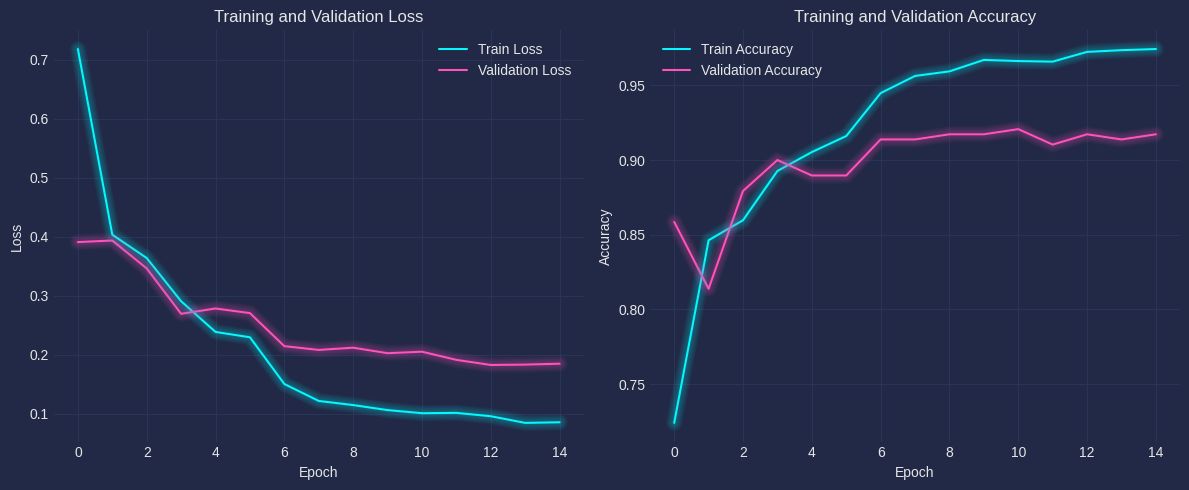

In [40]:
# Plotting training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()

plt.tight_layout()
plt.show()

11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 582ms/step


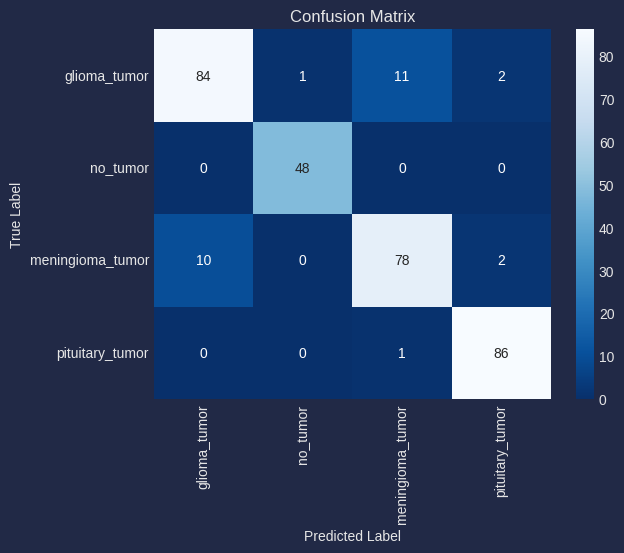

In [41]:
y_true_test = np.argmax(y_test, axis=1)
y_pred_test = np.argmax(model.predict(X_test), axis=1)

heatmap = sns.heatmap(confusion_matrix(y_true_test,y_pred_test), annot=True, fmt='d', cmap='Blues_r',
                      xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [42]:
print(classification_report(y_true_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.89      0.86      0.88        98
           1       0.98      1.00      0.99        48
           2       0.87      0.87      0.87        90
           3       0.96      0.99      0.97        87

    accuracy                           0.92       323
   macro avg       0.92      0.93      0.93       323
weighted avg       0.92      0.92      0.92       323



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted label: glioma_tumor 
Actual label: glioma_tumor 
Confidence: 100.00%



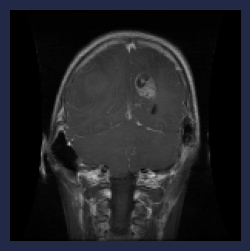

In [44]:
random_index = np.random.randint(0, len(X_test))
random_img = X_test[random_index]
predictions = model.predict(random_img.reshape(1, 150, 150, 3))  # Reshape and preprocess the image

# Interpret the model's predictions
predicted_class = np.argmax(predictions)  # Get the index of the class with the highest probability
predicted_label = labels[predicted_class]  # Convert class to label
confidence = predictions[0][predicted_class]

actual_index = y_test[random_index]  # Get the one-hot encoded actual class
actual_class = np.argmax(actual_index)
actual_label = labels[actual_class]

# Display the image and prediction information
print(f"\033[94mPredicted label: {predicted_label}\033[0m \n\033[92mActual label: {actual_label}\033[0m \n\033[93mConfidence: {confidence*100:.2f}%\033[0m\n")
plt.figure(figsize = (3,3))
plt.imshow(random_img)
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted label: pituitary_tumor 
Actual label: pituitary_tumor 
Confidence: 100.00%



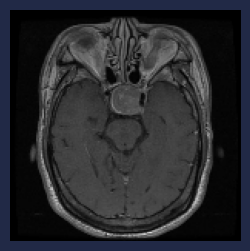

In [45]:
random_index = np.random.randint(0, len(X_test))
random_img = X_test[random_index]
predictions = model.predict(random_img.reshape(1, 150, 150, 3))  # Reshape and preprocess the image

# Interpret the model's predictions
predicted_class = np.argmax(predictions)  # Get the index of the class with the highest probability
predicted_label = labels[predicted_class]  # Convert class to label
confidence = predictions[0][predicted_class]

actual_index = y_test[random_index]  # Get the one-hot encoded actual class
actual_class = np.argmax(actual_index)
actual_label = labels[actual_class]

# Display the image and prediction information
print(f"\033[94mPredicted label: {predicted_label}\033[0m \n\033[92mActual label: {actual_label}\033[0m \n\033[93mConfidence: {confidence*100:.2f}%\033[0m\n")
plt.figure(figsize = (3,3))
plt.imshow(random_img)
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted label: no_tumor 
Actual label: no_tumor 
Confidence: 100.00%



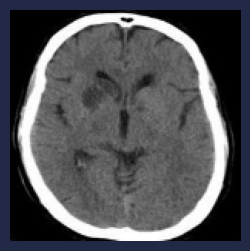

In [46]:
random_index = np.random.randint(0, len(X_test))
random_img = X_test[random_index]
predictions = model.predict(random_img.reshape(1, 150, 150, 3))  # Reshape and preprocess the image

# Interpret the model's predictions
predicted_class = np.argmax(predictions)  # Get the index of the class with the highest probability
predicted_label = labels[predicted_class]  # Convert class to label
confidence = predictions[0][predicted_class]

actual_index = y_test[random_index]  # Get the one-hot encoded actual class
actual_class = np.argmax(actual_index)
actual_label = labels[actual_class]

# Display the image and prediction information
print(f"\033[94mPredicted label: {predicted_label}\033[0m \n\033[92mActual label: {actual_label}\033[0m \n\033[93mConfidence: {confidence*100:.2f}%\033[0m\n")
plt.figure(figsize = (3,3))
plt.imshow(random_img)
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted label: no_tumor 
Actual label: no_tumor 
Confidence: 99.99%



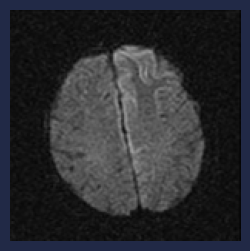

In [47]:
random_index = np.random.randint(0, len(X_test))
random_img = X_test[random_index]
predictions = model.predict(random_img.reshape(1, 150, 150, 3))  # Reshape and preprocess the image

# Interpret the model's predictions
predicted_class = np.argmax(predictions)  # Get the index of the class with the highest probability
predicted_label = labels[predicted_class]  # Convert class to label
confidence = predictions[0][predicted_class]

actual_index = y_test[random_index]  # Get the one-hot encoded actual class
actual_class = np.argmax(actual_index)
actual_label = labels[actual_class]

# Display the image and prediction information
print(f"\033[94mPredicted label: {predicted_label}\033[0m \n\033[92mActual label: {actual_label}\033[0m \n\033[93mConfidence: {confidence*100:.2f}%\033[0m\n")
plt.figure(figsize = (3,3))
plt.imshow(random_img)
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted label: glioma_tumor 
Actual label: glioma_tumor 
Confidence: 100.00%



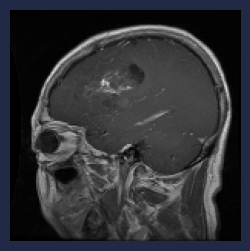

In [48]:
random_index = np.random.randint(0, len(X_test))
random_img = X_test[random_index]
predictions = model.predict(random_img.reshape(1, 150, 150, 3))  # Reshape and preprocess the image

# Interpret the model's predictions
predicted_class = np.argmax(predictions)  # Get the index of the class with the highest probability
predicted_label = labels[predicted_class]  # Convert class to label
confidence = predictions[0][predicted_class]

actual_index = y_test[random_index]  # Get the one-hot encoded actual class
actual_class = np.argmax(actual_index)
actual_label = labels[actual_class]

# Display the image and prediction information
print(f"\033[94mPredicted label: {predicted_label}\033[0m \n\033[92mActual label: {actual_label}\033[0m \n\033[93mConfidence: {confidence*100:.2f}%\033[0m\n")
plt.figure(figsize = (3,3))
plt.imshow(random_img)
plt.axis('off')
plt.show()

In [9]:
# Load the Xception model pretrained on ImageNet without the top layers
xception = tf.keras.applications.Xception(weights='imagenet', include_top=False,
                                          input_shape=(image_size, image_size, 3))

# Build the custom model on top of the Xception base
model = xception.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dense(1536,activation='relu')(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=xception.input, outputs = model)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 150, 150, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 74, 74, 32)     │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 74, 74, 32)     │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 74, 74, 32)     │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 72, 72, 64)     │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 72, 72, 64)     │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 72, 72, 64)     │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 72, 72, 128)    │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 72, 72, 128)    │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 72, 72, 128)    │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 72, 72, 128)    │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 72, 72, 128)    │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 36, 36, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 36, 36, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization  

 Total params: 24,014,892 (91.61 MB)

 Trainable params: 23,960,364 (91.40 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [13]:
# Tensorboard callback for logging training metrics
tensorboard = TensorBoard(log_dir='logs')

# Modelcheckpoint callback to save the best model
checkpoint = ModelCheckpoint("xception_best_model.keras", monitor="val_accuracy",
                             save_best_only=True, verbose=1)

# ReduceLROnPlateau callback to reduce learning rate if validation accuracy plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2,
                              min_delta=0.0001, verbose=1)

In [14]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.9895 - loss: 0.0279
Epoch 1: val_accuracy improved from -inf to 0.96897, saving model to xception_best_model.keras
82/82 ━━━━━━━━━━━━━━━━━━━━ 19s 237ms/step - accuracy: 0.9895 - loss: 0.0279 - val_accuracy: 0.9690 - val_loss: 0.0940 - learning_rate: 0.0010
Epoch 2/12
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.9772 - loss: 0.0874
Epoch 2: val_accuracy did not improve from 0.96897
82/82 ━━━━━━━━━━━━━━━━━━━━ 19s 216ms/step - accuracy: 0.9772 - loss: 0.0873 - val_accuracy: 0.7759 - val_loss: 0.7135 - learning_rate: 0.0010
Epoch 3/12
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.9769 - loss: 0.1195
Epoch 3: val_accuracy did not improve from 0.96897

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
82/82 ━━━━━━━━━━━━━━━━━━━━ 20s 212ms/step - accuracy: 0.9770 - loss: 0.1188 - val_accuracy: 0.9276 - val_loss: 0.2362 - learning_rate: 0.0010
Epoch 4/12
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 

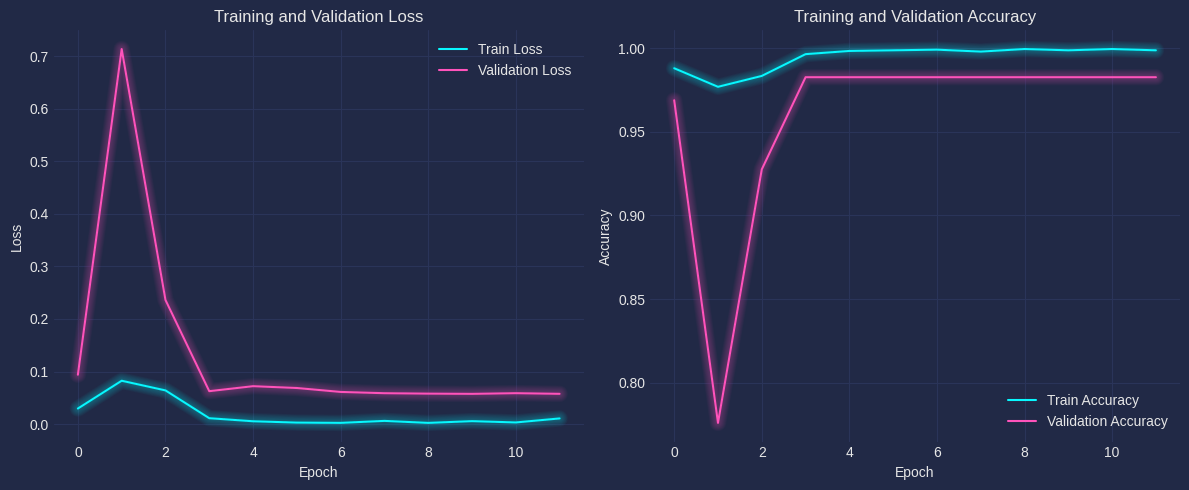

In [15]:
# Plotting training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()

plt.tight_layout()
plt.show()

11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 361ms/step


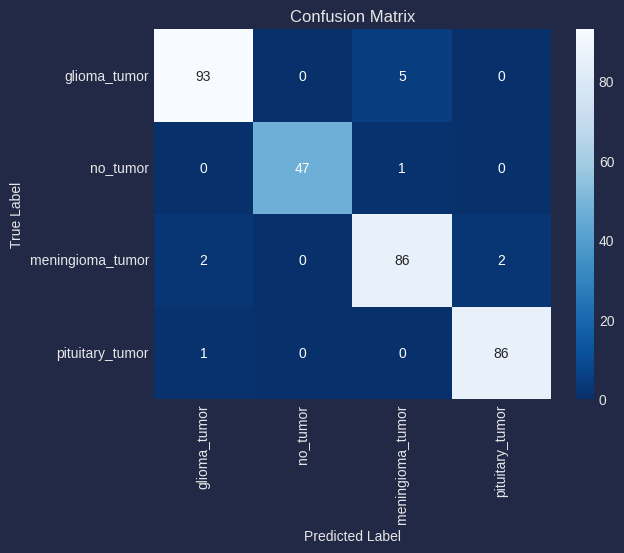

In [16]:
y_true_test = np.argmax(y_test, axis=1)
y_pred_test = np.argmax(model.predict(X_test), axis=1)

heatmap = sns.heatmap(confusion_matrix(y_true_test,y_pred_test), annot=True, fmt='d', cmap='Blues_r',
                      xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [17]:
print(classification_report(y_true_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96        98
           1       1.00      0.98      0.99        48
           2       0.93      0.96      0.95        90
           3       0.98      0.99      0.98        87

    accuracy                           0.97       323
   macro avg       0.97      0.97      0.97       323
weighted avg       0.97      0.97      0.97       323



1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predicted label: meningioma_tumor 
Actual label: meningioma_tumor 
Confidence: 100.00%



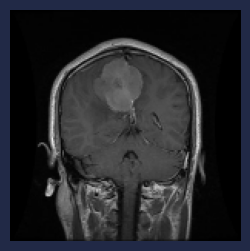

In [18]:
random_index = np.random.randint(0, len(X_test))
random_img = X_test[random_index]
predictions = model.predict(random_img.reshape(1, 150, 150, 3))  # Reshape and preprocess the image

# Interpret the model's predictions
predicted_class = np.argmax(predictions)  # Get the index of the class with the highest probability
predicted_label = labels[predicted_class]  # Convert class to label
confidence = predictions[0][predicted_class]

actual_index = y_test[random_index]  # Get the one-hot encoded actual class
actual_class = np.argmax(actual_index)
actual_label = labels[actual_class]

# Display the image and prediction information
print(f"\033[94mPredicted label: {predicted_label}\033[0m \n\033[92mActual label: {actual_label}\033[0m \n\033[93mConfidence: {confidence*100:.2f}%\033[0m\n")
plt.figure(figsize = (3,3))
plt.imshow(random_img)
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted label: pituitary_tumor 
Actual label: pituitary_tumor 
Confidence: 100.00%



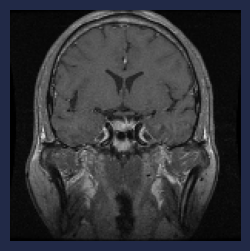

In [19]:
random_index = np.random.randint(0, len(X_test))
random_img = X_test[random_index]
predictions = model.predict(random_img.reshape(1, 150, 150, 3))  # Reshape and preprocess the image

# Interpret the model's predictions
predicted_class = np.argmax(predictions)  # Get the index of the class with the highest probability
predicted_label = labels[predicted_class]  # Convert class to label
confidence = predictions[0][predicted_class]

actual_index = y_test[random_index]  # Get the one-hot encoded actual class
actual_class = np.argmax(actual_index)
actual_label = labels[actual_class]

# Display the image and prediction information
print(f"\033[94mPredicted label: {predicted_label}\033[0m \n\033[92mActual label: {actual_label}\033[0m \n\033[93mConfidence: {confidence*100:.2f}%\033[0m\n")
plt.figure(figsize = (3,3))
plt.imshow(random_img)
plt.axis('off')
plt.show()

In [22]:
import optuna
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau

# Verinin olduğu dizinler
train_dir = "/content/drive/My Drive/DataSets/Training"  # Eğitim verisi yolu
val_dir = "/content/drive/My Drive/DataSets/Testing"      # Doğrulama verisi yolu

# Görüntü boyutu
IMG_SIZE = (150, 150)  # ResNet50 için de bu boyut kullanılabilir

# Veri yükleme için ImageDataGenerator kullanımı
train_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=32, class_mode="categorical"
)
val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=IMG_SIZE, batch_size=32, class_mode="categorical"
)

# Hiperparametreleri optimize eden fonksiyon
def objective(trial):
    # Hiperparametre aralıklarını belirleme
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
    dense_units = trial.suggest_int("dense_units", 128, 1024, step=128)
    dropout_rate = trial.suggest_uniform("dropout_rate", 0.2, 0.5)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])

    # ResNet50 modeli
    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    base_model.trainable = False  # Transfer learning için donduruyoruz

    # Üst katmanları inşa etme
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(dense_units, activation="relu")(x)
    x = Dropout(dropout_rate)(x)
    output = Dense(train_generator.num_classes, activation="softmax")(x)

    model = Model(inputs=base_model.input, outputs=output)

    # Callback'leri tanımlama
    tensorboard = TensorBoard(log_dir='logs')
    checkpoint = ModelCheckpoint("xception_best_model.keras", monitor="val_accuracy",
                                 save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2,
                                  min_delta=0.0001, verbose=1)

    # Model derleme
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    # Modeli eğitme
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=5,  # Daha büyük veri setlerinde artırılabilir
        batch_size=batch_size,  # Not: Generator zaten batch_size belirtiyor,
                                # bu parametre fit()'te genelde kullanılmaz ama burada denemek için bırakıldı.
        callbacks=[tensorboard, checkpoint, reduce_lr],
        verbose=0  # Optuna için sessiz çalıştırma
    )

    # En iyi doğrulama doğruluğunu döndür
    val_accuracy = max(history.history["val_accuracy"])
    return val_accuracy

# Optuna çalıştırma
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

# En iyi hiperparametreleri yazdırma
print("En iyi hiperparametreler: ", study.best_params)

Found 2880 images belonging to 4 classes.
Found 342 images belonging to 4 classes.


[I 2025-02-22 13:24:17,515] A new study created in memory with name: no-name-c91e0d8b-8b31-440a-a08b-f0b4d191c3f2
<ipython-input-22-bc85c147ea00>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-22-bc85c147ea00>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform("dropout_rate", 0.2, 0.5)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass t


Epoch 1: val_accuracy improved from -inf to 0.35380, saving model to xception_best_model.keras

Epoch 2: val_accuracy did not improve from 0.35380

Epoch 3: val_accuracy did not improve from 0.35380

Epoch 3: ReduceLROnPlateau reducing learning rate to 6.002166774123907e-05.

Epoch 4: val_accuracy did not improve from 0.35380

Epoch 5: val_accuracy did not improve from 0.35380

Epoch 5: ReduceLROnPlateau reducing learning rate to 6.002166628604755e-06.


[I 2025-02-22 13:26:50,835] Trial 0 finished with value: 0.3538011610507965 and parameters: {'learning_rate': 0.0006002166781900306, 'dense_units': 512, 'dropout_rate': 0.3015274681063905, 'batch_size': 16}. Best is trial 0 with value: 0.3538011610507965.



Epoch 1: val_accuracy improved from -inf to 0.23392, saving model to xception_best_model.keras

Epoch 2: val_accuracy improved from 0.23392 to 0.34795, saving model to xception_best_model.keras

Epoch 3: val_accuracy did not improve from 0.34795

Epoch 4: val_accuracy improved from 0.34795 to 0.35380, saving model to xception_best_model.keras

Epoch 5: val_accuracy improved from 0.35380 to 0.35965, saving model to xception_best_model.keras


[I 2025-02-22 13:28:40,224] Trial 1 finished with value: 0.359649121761322 and parameters: {'learning_rate': 2.2470228694019888e-05, 'dense_units': 128, 'dropout_rate': 0.22700836848667552, 'batch_size': 64}. Best is trial 1 with value: 0.359649121761322.



Epoch 1: val_accuracy improved from -inf to 0.33918, saving model to xception_best_model.keras

Epoch 2: val_accuracy did not improve from 0.33918

Epoch 3: val_accuracy improved from 0.33918 to 0.34211, saving model to xception_best_model.keras

Epoch 4: val_accuracy did not improve from 0.34211

Epoch 5: val_accuracy improved from 0.34211 to 0.36550, saving model to xception_best_model.keras


[I 2025-02-22 13:30:17,072] Trial 2 finished with value: 0.36549708247184753 and parameters: {'learning_rate': 0.0025198867127570962, 'dense_units': 896, 'dropout_rate': 0.4720499931057262, 'batch_size': 32}. Best is trial 2 with value: 0.36549708247184753.



Epoch 1: val_accuracy improved from -inf to 0.35380, saving model to xception_best_model.keras

Epoch 2: val_accuracy did not improve from 0.35380

Epoch 3: val_accuracy did not improve from 0.35380

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0009255710989236832.

Epoch 4: val_accuracy did not improve from 0.35380

Epoch 5: val_accuracy did not improve from 0.35380

Epoch 5: ReduceLROnPlateau reducing learning rate to 9.255710756406188e-05.


[I 2025-02-22 13:31:49,226] Trial 3 finished with value: 0.3538011610507965 and parameters: {'learning_rate': 0.009255711284898684, 'dense_units': 128, 'dropout_rate': 0.39459505731877065, 'batch_size': 16}. Best is trial 2 with value: 0.36549708247184753.



Epoch 1: val_accuracy improved from -inf to 0.29532, saving model to xception_best_model.keras

Epoch 2: val_accuracy improved from 0.29532 to 0.29825, saving model to xception_best_model.keras

Epoch 3: val_accuracy improved from 0.29825 to 0.33333, saving model to xception_best_model.keras

Epoch 4: val_accuracy did not improve from 0.33333

Epoch 5: val_accuracy improved from 0.33333 to 0.34211, saving model to xception_best_model.keras


[I 2025-02-22 13:33:34,440] Trial 4 finished with value: 0.34210526943206787 and parameters: {'learning_rate': 0.00023903796638007188, 'dense_units': 384, 'dropout_rate': 0.22334553949180852, 'batch_size': 32}. Best is trial 2 with value: 0.36549708247184753.



Epoch 1: val_accuracy improved from -inf to 0.34211, saving model to xception_best_model.keras

Epoch 2: val_accuracy improved from 0.34211 to 0.35673, saving model to xception_best_model.keras

Epoch 3: val_accuracy did not improve from 0.35673

Epoch 4: val_accuracy did not improve from 0.35673

Epoch 4: ReduceLROnPlateau reducing learning rate to 4.314994657761417e-06.

Epoch 5: val_accuracy did not improve from 0.35673


[I 2025-02-22 13:35:09,114] Trial 5 finished with value: 0.35672515630722046 and parameters: {'learning_rate': 4.314994610947301e-05, 'dense_units': 1024, 'dropout_rate': 0.40959176091798377, 'batch_size': 64}. Best is trial 2 with value: 0.36549708247184753.



Epoch 1: val_accuracy improved from -inf to 0.28363, saving model to xception_best_model.keras

Epoch 2: val_accuracy improved from 0.28363 to 0.30409, saving model to xception_best_model.keras

Epoch 3: val_accuracy did not improve from 0.30409

Epoch 4: val_accuracy improved from 0.30409 to 0.35673, saving model to xception_best_model.keras

Epoch 5: val_accuracy did not improve from 0.35673


[I 2025-02-22 13:36:55,549] Trial 6 finished with value: 0.35672515630722046 and parameters: {'learning_rate': 0.00494562635800544, 'dense_units': 128, 'dropout_rate': 0.362594365571681, 'batch_size': 64}. Best is trial 2 with value: 0.36549708247184753.



Epoch 1: val_accuracy improved from -inf to 0.26901, saving model to xception_best_model.keras

Epoch 2: val_accuracy improved from 0.26901 to 0.29532, saving model to xception_best_model.keras

Epoch 3: val_accuracy improved from 0.29532 to 0.30702, saving model to xception_best_model.keras

Epoch 4: val_accuracy improved from 0.30702 to 0.32456, saving model to xception_best_model.keras

Epoch 5: val_accuracy did not improve from 0.32456


[I 2025-02-22 13:38:42,632] Trial 7 finished with value: 0.3245614171028137 and parameters: {'learning_rate': 1.686836310531606e-05, 'dense_units': 512, 'dropout_rate': 0.27126092270618046, 'batch_size': 32}. Best is trial 2 with value: 0.36549708247184753.



Epoch 1: val_accuracy improved from -inf to 0.29825, saving model to xception_best_model.keras

Epoch 2: val_accuracy improved from 0.29825 to 0.35088, saving model to xception_best_model.keras

Epoch 3: val_accuracy improved from 0.35088 to 0.35380, saving model to xception_best_model.keras

Epoch 4: val_accuracy did not improve from 0.35380

Epoch 5: val_accuracy did not improve from 0.35380

Epoch 5: ReduceLROnPlateau reducing learning rate to 7.30268016923219e-05.


[I 2025-02-22 13:40:23,983] Trial 8 finished with value: 0.3538011610507965 and parameters: {'learning_rate': 0.0007302680142937198, 'dense_units': 256, 'dropout_rate': 0.46876814833325325, 'batch_size': 64}. Best is trial 2 with value: 0.36549708247184753.



Epoch 1: val_accuracy improved from -inf to 0.34211, saving model to xception_best_model.keras

Epoch 2: val_accuracy did not improve from 0.34211

Epoch 3: val_accuracy did not improve from 0.34211

Epoch 3: ReduceLROnPlateau reducing learning rate to 1.1828110473288689e-06.

Epoch 4: val_accuracy did not improve from 0.34211

Epoch 5: val_accuracy did not improve from 0.34211

Epoch 5: ReduceLROnPlateau reducing learning rate to 1.182811047328869e-07.


[I 2025-02-22 13:42:11,790] Trial 9 finished with value: 0.34210526943206787 and parameters: {'learning_rate': 1.1828110505602245e-05, 'dense_units': 128, 'dropout_rate': 0.3959811724552328, 'batch_size': 64}. Best is trial 2 with value: 0.36549708247184753.



Epoch 1: val_accuracy improved from -inf to 0.33918, saving model to xception_best_model.keras

Epoch 2: val_accuracy improved from 0.33918 to 0.42690, saving model to xception_best_model.keras

Epoch 3: val_accuracy did not improve from 0.42690

Epoch 4: val_accuracy did not improve from 0.42690

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002632011426612735.

Epoch 5: val_accuracy did not improve from 0.42690


[I 2025-02-22 13:43:46,855] Trial 10 finished with value: 0.42690059542655945 and parameters: {'learning_rate': 0.002632011451398639, 'dense_units': 896, 'dropout_rate': 0.49636115886592497, 'batch_size': 32}. Best is trial 10 with value: 0.42690059542655945.



Epoch 1: val_accuracy improved from -inf to 0.35965, saving model to xception_best_model.keras

Epoch 2: val_accuracy did not improve from 0.35965

Epoch 3: val_accuracy did not improve from 0.35965

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00023417326156049967.

Epoch 4: val_accuracy did not improve from 0.35965

Epoch 5: val_accuracy did not improve from 0.35965

Epoch 5: ReduceLROnPlateau reducing learning rate to 2.341732615604997e-05.


[I 2025-02-22 13:45:18,679] Trial 11 finished with value: 0.359649121761322 and parameters: {'learning_rate': 0.0023417326051688, 'dense_units': 896, 'dropout_rate': 0.4880286000288453, 'batch_size': 32}. Best is trial 10 with value: 0.42690059542655945.



Epoch 1: val_accuracy improved from -inf to 0.30117, saving model to xception_best_model.keras

Epoch 2: val_accuracy improved from 0.30117 to 0.32164, saving model to xception_best_model.keras

Epoch 3: val_accuracy improved from 0.32164 to 0.33918, saving model to xception_best_model.keras

Epoch 4: val_accuracy improved from 0.33918 to 0.35380, saving model to xception_best_model.keras

Epoch 5: val_accuracy improved from 0.35380 to 0.37135, saving model to xception_best_model.keras


[I 2025-02-22 13:47:19,211] Trial 12 finished with value: 0.37134504318237305 and parameters: {'learning_rate': 0.0017468747681596824, 'dense_units': 768, 'dropout_rate': 0.45611244443227655, 'batch_size': 32}. Best is trial 10 with value: 0.42690059542655945.



Epoch 1: val_accuracy improved from -inf to 0.28070, saving model to xception_best_model.keras

Epoch 2: val_accuracy did not improve from 0.28070

Epoch 3: val_accuracy improved from 0.28070 to 0.33918, saving model to xception_best_model.keras

Epoch 4: val_accuracy did not improve from 0.33918

Epoch 5: val_accuracy improved from 0.33918 to 0.36257, saving model to xception_best_model.keras


[I 2025-02-22 13:49:15,433] Trial 13 finished with value: 0.3625730872154236 and parameters: {'learning_rate': 0.0012906865989954703, 'dense_units': 768, 'dropout_rate': 0.43749221779219893, 'batch_size': 32}. Best is trial 10 with value: 0.42690059542655945.



Epoch 1: val_accuracy improved from -inf to 0.34795, saving model to xception_best_model.keras

Epoch 2: val_accuracy did not improve from 0.34795

Epoch 3: val_accuracy did not improve from 0.34795

Epoch 3: ReduceLROnPlateau reducing learning rate to 1.189661561511457e-05.

Epoch 4: val_accuracy did not improve from 0.34795

Epoch 5: val_accuracy did not improve from 0.34795

Epoch 5: ReduceLROnPlateau reducing learning rate to 1.189661543321563e-06.


[I 2025-02-22 13:50:50,036] Trial 14 finished with value: 0.3479532301425934 and parameters: {'learning_rate': 0.00011896615759285719, 'dense_units': 768, 'dropout_rate': 0.49575398606142773, 'batch_size': 32}. Best is trial 10 with value: 0.42690059542655945.



Epoch 1: val_accuracy improved from -inf to 0.36257, saving model to xception_best_model.keras

Epoch 2: val_accuracy did not improve from 0.36257

Epoch 3: val_accuracy did not improve from 0.36257

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00032991501502692704.

Epoch 4: val_accuracy did not improve from 0.36257

Epoch 5: val_accuracy did not improve from 0.36257

Epoch 5: ReduceLROnPlateau reducing learning rate to 3.299150266684592e-05.


[I 2025-02-22 13:52:39,907] Trial 15 finished with value: 0.3625730872154236 and parameters: {'learning_rate': 0.003299150108548448, 'dense_units': 640, 'dropout_rate': 0.43730789575343676, 'batch_size': 32}. Best is trial 10 with value: 0.42690059542655945.



Epoch 1: val_accuracy improved from -inf to 0.28947, saving model to xception_best_model.keras

Epoch 2: val_accuracy did not improve from 0.28947

Epoch 3: val_accuracy improved from 0.28947 to 0.36842, saving model to xception_best_model.keras

Epoch 4: val_accuracy did not improve from 0.36842

Epoch 5: val_accuracy improved from 0.36842 to 0.39474, saving model to xception_best_model.keras


[I 2025-02-22 13:54:41,829] Trial 16 finished with value: 0.3947368562221527 and parameters: {'learning_rate': 0.00106511286613742, 'dense_units': 1024, 'dropout_rate': 0.338126343951917, 'batch_size': 32}. Best is trial 10 with value: 0.42690059542655945.



Epoch 1: val_accuracy improved from -inf to 0.33626, saving model to xception_best_model.keras

Epoch 2: val_accuracy did not improve from 0.33626

Epoch 3: val_accuracy improved from 0.33626 to 0.37135, saving model to xception_best_model.keras

Epoch 4: val_accuracy did not improve from 0.37135

Epoch 5: val_accuracy did not improve from 0.37135

Epoch 5: ReduceLROnPlateau reducing learning rate to 4.10623528296128e-05.


[I 2025-02-22 13:56:30,574] Trial 17 finished with value: 0.37134504318237305 and parameters: {'learning_rate': 0.00041062353414213015, 'dense_units': 1024, 'dropout_rate': 0.3270432203664143, 'batch_size': 16}. Best is trial 10 with value: 0.42690059542655945.



Epoch 1: val_accuracy improved from -inf to 0.36257, saving model to xception_best_model.keras

Epoch 2: val_accuracy did not improve from 0.36257

Epoch 3: val_accuracy did not improve from 0.36257

Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9228077144362034e-05.

Epoch 4: val_accuracy did not improve from 0.36257

Epoch 5: val_accuracy did not improve from 0.36257

Epoch 5: ReduceLROnPlateau reducing learning rate to 1.922807678056415e-06.


[I 2025-02-22 13:58:11,296] Trial 18 finished with value: 0.3625730872154236 and parameters: {'learning_rate': 0.00019228076447581915, 'dense_units': 1024, 'dropout_rate': 0.35350151054321044, 'batch_size': 32}. Best is trial 10 with value: 0.42690059542655945.



Epoch 1: val_accuracy improved from -inf to 0.35673, saving model to xception_best_model.keras

Epoch 2: val_accuracy did not improve from 0.35673

Epoch 3: val_accuracy did not improve from 0.35673

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0009852683171629906.

Epoch 4: val_accuracy did not improve from 0.35673

Epoch 5: val_accuracy improved from 0.35673 to 0.36550, saving model to xception_best_model.keras


[I 2025-02-22 14:00:09,871] Trial 19 finished with value: 0.36549708247184753 and parameters: {'learning_rate': 0.00985268307317802, 'dense_units': 896, 'dropout_rate': 0.2958699039315011, 'batch_size': 32}. Best is trial 10 with value: 0.42690059542655945.


En iyi hiperparametreler:  {'learning_rate': 0.002632011451398639, 'dense_units': 896, 'dropout_rate': 0.49636115886592497, 'batch_size': 32}


In [7]:
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau

# Optuna ile bulunan en iyi hiperparametreler
best_learning_rate = 0.002632011451398639
best_dense_units = 896
best_dropout_rate = 0.49636115886592497
best_batch_size = 32

# Xception modelini yükle (ImageNet ağırlıklarıyla, top katmanı olmadan)
base_model = Xception(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False  # Transfer learning için temel modeli dondur

# Modelin üzerine özel katmanları ekle
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(best_dense_units, activation='relu')(x)
x = Dropout(best_dropout_rate)(x)
x = Dense(4, activation='softmax')(x)  # 4 sınıflı çıktı

# Modeli oluştur
model = Model(inputs=base_model.input, outputs=x)

# Modeli derle
model.compile(optimizer=Adam(learning_rate=best_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks tanımla
tensorboard = TensorBoard(log_dir='logs')

checkpoint = ModelCheckpoint("xception_best_model.keras", monitor="val_accuracy",
                             save_best_only=True, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2,
                              min_delta=0.0001, verbose=1)

# Modeli eğit
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=12,
    verbose=1,
    batch_size=best_batch_size,
    callbacks=[tensorboard, checkpoint, reduce_lr]
)


Epoch 1/12
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.4047 - loss: 15.2551
Epoch 1: val_accuracy improved from -inf to 0.70690, saving model to xception_best_model.keras
82/82 ━━━━━━━━━━━━━━━━━━━━ 30s 194ms/step - accuracy: 0.4055 - loss: 15.1458 - val_accuracy: 0.7069 - val_loss: 0.9251 - learning_rate: 0.0026
Epoch 2/12
81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.5749 - loss: 1.0552
Epoch 2: val_accuracy did not improve from 0.70690
82/82 ━━━━━━━━━━━━━━━━━━━━ 21s 62ms/step - accuracy: 0.5751 - loss: 1.0547 - val_accuracy: 0.6241 - val_loss: 0.8643 - learning_rate: 0.0026
Epoch 3/12
81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.5997 - loss: 0.9382
Epoch 3: val_accuracy did not improve from 0.70690

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0002632011426612735.
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.5999 - loss: 0.9378 - val_accuracy: 0.6966 - val_loss: 0.7686 - learning_rate: 0.0026
Epoch 4/12
81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms

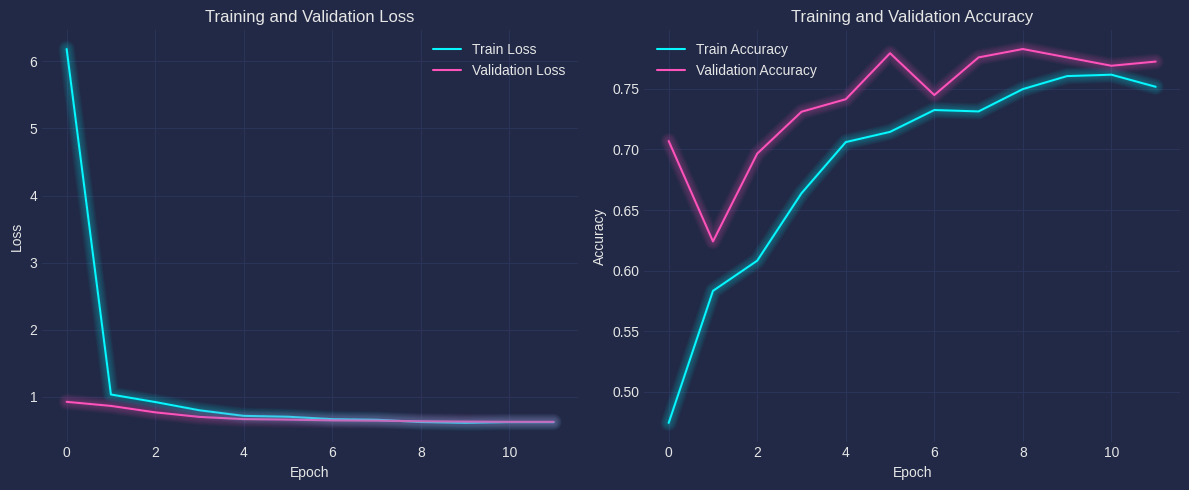

In [8]:
# Plotting training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()

plt.tight_layout()
plt.show()

11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 365ms/step


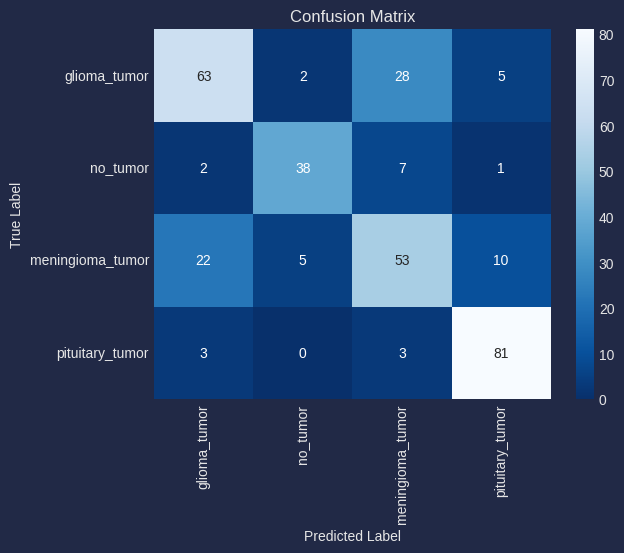

In [9]:
y_true_test = np.argmax(y_test, axis=1)
y_pred_test = np.argmax(model.predict(X_test), axis=1)

heatmap = sns.heatmap(confusion_matrix(y_true_test,y_pred_test), annot=True, fmt='d', cmap='Blues_r',
                      xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [10]:
print(classification_report(y_true_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.70      0.64      0.67        98
           1       0.84      0.79      0.82        48
           2       0.58      0.59      0.59        90
           3       0.84      0.93      0.88        87

    accuracy                           0.73       323
   macro avg       0.74      0.74      0.74       323
weighted avg       0.73      0.73      0.73       323



1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted label: pituitary_tumor 
Actual label: pituitary_tumor 
Confidence: 96.95%



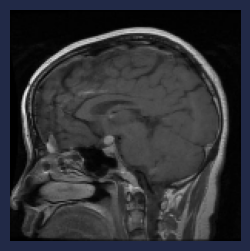

In [11]:
random_index = np.random.randint(0, len(X_test))
random_img = X_test[random_index]
predictions = model.predict(random_img.reshape(1, 150, 150, 3))  # Reshape and preprocess the image

# Interpret the model's predictions
predicted_class = np.argmax(predictions)  # Get the index of the class with the highest probability
predicted_label = labels[predicted_class]  # Convert class to label
confidence = predictions[0][predicted_class]

actual_index = y_test[random_index]  # Get the one-hot encoded actual class
actual_class = np.argmax(actual_index)
actual_label = labels[actual_class]

# Display the image and prediction information
print(f"\033[94mPredicted label: {predicted_label}\033[0m \n\033[92mActual label: {actual_label}\033[0m \n\033[93mConfidence: {confidence*100:.2f}%\033[0m\n")
plt.figure(figsize = (3,3))
plt.imshow(random_img)
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Predicted label: meningioma_tumor 
Actual label: meningioma_tumor 
Confidence: 50.38%



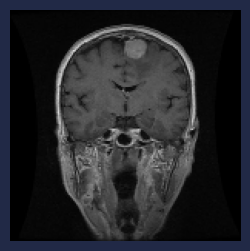

In [12]:
random_index = np.random.randint(0, len(X_test))
random_img = X_test[random_index]
predictions = model.predict(random_img.reshape(1, 150, 150, 3))  # Reshape and preprocess the image

# Interpret the model's predictions
predicted_class = np.argmax(predictions)  # Get the index of the class with the highest probability
predicted_label = labels[predicted_class]  # Convert class to label
confidence = predictions[0][predicted_class]

actual_index = y_test[random_index]  # Get the one-hot encoded actual class
actual_class = np.argmax(actual_index)
actual_label = labels[actual_class]

# Display the image and prediction information
print(f"\033[94mPredicted label: {predicted_label}\033[0m \n\033[92mActual label: {actual_label}\033[0m \n\033[93mConfidence: {confidence*100:.2f}%\033[0m\n")
plt.figure(figsize = (3,3))
plt.imshow(random_img)
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Predicted label: meningioma_tumor 
Actual label: meningioma_tumor 
Confidence: 59.60%



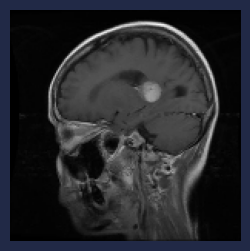

In [16]:
random_index = np.random.randint(0, len(X_test))
random_img = X_test[random_index]
predictions = model.predict(random_img.reshape(1, 150, 150, 3))  # Reshape and preprocess the image

# Interpret the model's predictions
predicted_class = np.argmax(predictions)  # Get the index of the class with the highest probability
predicted_label = labels[predicted_class]  # Convert class to label
confidence = predictions[0][predicted_class]

actual_index = y_test[random_index]  # Get the one-hot encoded actual class
actual_class = np.argmax(actual_index)
actual_label = labels[actual_class]

# Display the image and prediction information
print(f"\033[94mPredicted label: {predicted_label}\033[0m \n\033[92mActual label: {actual_label}\033[0m \n\033[93mConfidence: {confidence*100:.2f}%\033[0m\n")
plt.figure(figsize = (3,3))
plt.imshow(random_img)
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Predicted label: meningioma_tumor 
Actual label: meningioma_tumor 
Confidence: 48.62%



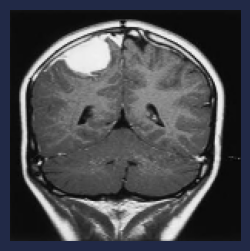

In [15]:
random_index = np.random.randint(0, len(X_test))
random_img = X_test[random_index]
predictions = model.predict(random_img.reshape(1, 150, 150, 3))  # Reshape and preprocess the image

# Interpret the model's predictions
predicted_class = np.argmax(predictions)  # Get the index of the class with the highest probability
predicted_label = labels[predicted_class]  # Convert class to label
confidence = predictions[0][predicted_class]

actual_index = y_test[random_index]  # Get the one-hot encoded actual class
actual_class = np.argmax(actual_index)
actual_label = labels[actual_class]

# Display the image and prediction information
print(f"\033[94mPredicted label: {predicted_label}\033[0m \n\033[92mActual label: {actual_label}\033[0m \n\033[93mConfidence: {confidence*100:.2f}%\033[0m\n")
plt.figure(figsize = (3,3))
plt.imshow(random_img)
plt.axis('off')
plt.show()